In [1]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer, AutoProcessor
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

/home/dungchu/ai_project/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "5CD-AI/Vintern-Embedding-1B"

model = AutoModel.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,       
    low_cpu_mem_usage=True,
    trust_remote_code=True,
).eval().cuda()

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-Embedding-1B:
- configuration_internvl_chat.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-Embedding-1B:
- modeling_colinternvl2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/home/dungchu/ai_project/env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Parameter containing:
tensor(..., device='meta', size=(151674, 896), requires_grad=True)


In [8]:
processor = AutoProcessor.from_pretrained(
    model_name,
    trust_remote_code=True
)

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-Embedding-1B:
- processing_colinternvl2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [19]:
# 2. Tải model và processor
model_name = "5CD-AI/ColVintern-1B-v1"
print(f"🧠 Đang tải model '{model_name}'...")
# 1. Chuẩn bị thiết bị (GPU nếu có)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 Đang sử dụng thiết bị: {device}")
# Tải processor để chuẩn bị dữ liệu
processor = AutoProcessor.from_pretrained(
    model_name,
    trust_remote_code=True
)

# Tải model chính
# torch_dtype="auto" sẽ tự động dùng bfloat16 trên GPU tương thích để tối ưu
model = AutoModel.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype="auto"
).eval().to(device)

print("🎉 Tải Model và Processor thành công!")

🧠 Đang tải model '5CD-AI/ColVintern-1B-v1'...
🔧 Đang sử dụng thiết bị: cuda


A new version of the following files was downloaded from https://huggingface.co/5CD-AI/ColVintern-1B-v1:
- processing_colinternvl2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/ColVintern-1B-v1:
- configuration_internvl_chat.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


KeyboardInterrupt: 

In [ ]:


pdf_file_path = '/content/Sổ tay sinh viên K65 - 2024.pdf'
if not os.path.exists(pdf_file_path):
    print(f"⚠️ Vui lòng tải file '{pdf_file_path}' lên Google Colab.")

# --- 3.1: Khởi tạo ChromaDB ---
db_path = "./handbook_page_vectordb"
collection_name = "handbook_page_images"

client = chromadb.PersistentClient(path=db_path)
if collection_name in [c.name for c in client.list_collections()]:
    client.delete_collection(name=collection_name)
collection = client.create_collection(name=collection_name)
print(f"Đã tạo collection '{collection_name}' trong ChromaDB.")

# ==============================
# BƯỚC 3: TẠO DANH SÁCH ẢNH (PAGE_LIST)
# ==============================
page_list = []
print("📸 Bắt đầu chuyển đổi các trang PDF thành ảnh...")
doc = fitz.open(pdf_file_path)
for page in tqdm(doc, desc="Đang chụp ảnh các trang"):
    pix = page.get_pixmap(dpi=150) 
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    page_list.append(img)
print(f"✅ Đã tạo thành công danh sách `page_list` với {len(page_list)} ảnh.")


In [ ]:
image_embeddings_list = []

for i in tqdm(range(len(page_list))):  # ✅ SỬA: bỏ .tqdm
    batch_images = processor.process_images([page_list[i]])

    batch_images["pixel_values"] = batch_images["pixel_values"].cuda().bfloat16()
    batch_images["input_ids"] = batch_images["input_ids"].cuda() #.bfloat16()
    batch_images["attention_mask"] = batch_images["attention_mask"].cuda().bfloat16()

    with torch.no_grad():
        image_embeddings = model(**batch_images)

    image_embeddings_list.append(image_embeddings.squeeze())

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 Đang sử dụng thiết bị: {device}")

🔧 Đang sử dụng thiết bị: cuda


In [9]:
embedding_file = '/mnt/d/Nam5ki1/CDCNTT/UTC_student_handbook/ImageEmbeddings/page_embeddings.npy'
page_list_file = '/mnt/d/Nam5ki1/CDCNTT/UTC_student_handbook/ImageEmbeddings/page_list.pkl'

print(f"💾 Đang tìm và tải lại dữ liệu từ file '{embedding_file}' và '{page_list_file}'...")
# Vui lòng tải 2 file này lên Colab trước khi chạy
if os.path.exists(embedding_file) and os.path.exists(page_list_file):
    # Tải mảng embeddings từ file .npy
    loaded_embeddings_np = np.load(embedding_file)
    
    # Tải lại danh sách các đối tượng ảnh
    with open(page_list_file, 'rb') as f:
        page_list = pickle.load(f)
        
    # Chuyển đổi embeddings sang PyTorch Tensor để tính toán
    image_embeddings_tensor = torch.tensor(loaded_embeddings_np).to(device)
    
    # QUAN TRỌNG: Luôn chuẩn hóa embeddings trước khi tìm kiếm
    image_embeddings_tensor = torch.nn.functional.normalize(image_embeddings_tensor.float(), p=2, dim=1)
    
    print(f"✅ Tải lại thành công {len(page_list)} trang và embeddings tương ứng. Sẵn sàng để tìm kiếm!")
else:
    print(f"⚠️ Lỗi: Không tìm thấy file '{embedding_file}' hoặc '{page_list_file}'.")
print("-" * 50)

💾 Đang tìm và tải lại dữ liệu từ file '/mnt/d/Nam5ki1/CDCNTT/UTC_student_handbook/ImageEmbeddings/page_embeddings.npy' và '/mnt/d/Nam5ki1/CDCNTT/UTC_student_handbook/ImageEmbeddings/page_list.pkl'...
✅ Tải lại thành công 92 trang và embeddings tương ứng. Sẵn sàng để tìm kiếm!
--------------------------------------------------


In [6]:
def search_and_print(query, processor, model, doc_embeddings_list, raw_docs, top_k=5, device="cuda"):
    """
    Tìm kiếm và in ra kết quả top_k tài liệu liên quan đến query.
    - query: câu truy vấn (string)
    - processor: processor đã load
    - model: model encode query
    - doc_embeddings_list: list embedding tài liệu
    - raw_docs: list tài liệu gốc (text hoặc hình ảnh)
    - top_k: số kết quả muốn hiển thị
    """
    # Chuẩn bị batch query
    batch_queries = processor.process_queries([query])
    batch_queries["input_ids"] = batch_queries["input_ids"].to(device)
    batch_queries["attention_mask"] = batch_queries["attention_mask"].to(device).bfloat16()

    # Tính embedding query
    with torch.no_grad():
        query_embeddings = model(**batch_queries)

    # Tính điểm tương đồng
    scores = processor.score_multi_vector(query_embeddings, doc_embeddings_list)[0]
    top_indices = scores.argsort(descending=True)[:top_k]

    print(f"\n🔍 Kết quả tìm kiếm cho query: \"{query}\"\n")
    for rank, idx in enumerate(top_indices, start=1):
        score = scores[idx].item()
        doc = raw_docs[idx]

        print(f"#{rank} | Score: {score:.4f}")
        print("=" * 60)
        if isinstance(doc, str):
            print(f"📄 Văn bản: {doc}\n")
        else:
            print("🖼️ Hình ảnh:")
            plt.figure(figsize=(10, 10))
            plt.imshow(doc)
            plt.axis("off")
            plt.show()


🔍 Kết quả tìm kiếm cho query: "Các bến xe nhà trường"

#1 | Score: 6.7218
🖼️ Hình ảnh:


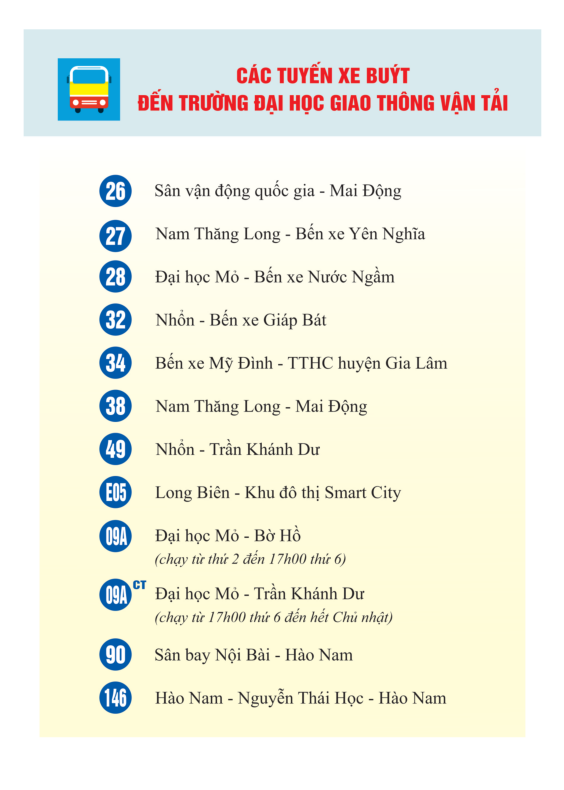

#2 | Score: 6.3276
🖼️ Hình ảnh:


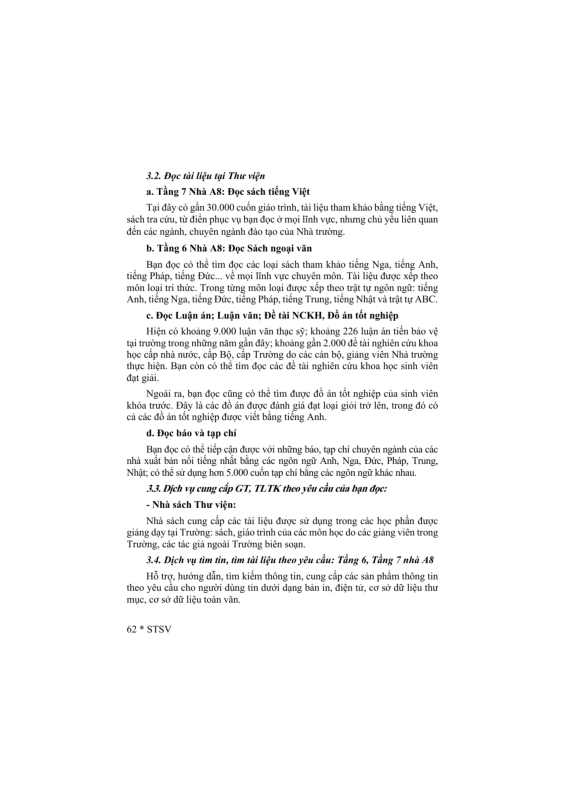

In [10]:
query = "Các bến xe nhà trường"

search_and_print(query, processor, model, image_embeddings_tensor, page_list, top_k=2)